# Quantum Max Cut

Having experimented with the max flow algorithm, as well as finding the minimum cut in notebook `1-data-preparation` using Google's `ortools` library, we will now try to apply **DWave** and their simulated quantum tools to solve a similar problem. In this case, we will look for the **max cut** in our graph, i.e., splitting the graph into two sets, such that the weight of edges connecting vertices in different sets is maximized.

In [1]:
# Load Data
import geopandas as gpd

gdf_edges = gpd.read_file("../data/gdf_edges.geojson") # Read bi-directional edges
gdf_nodes = gpd.read_file("../data/gdf_nodes.geojson") # Read nodes

# Important: We found that some nodes are related to itself further down the line in this notebook. We remove them here:
gdf_edges = gdf_edges[~(gdf_edges.start_node == gdf_edges.end_node)]

# Create an undirected graph
import networkx as nx
G = nx.Graph()
for _, row in gdf_nodes.iterrows():
    G.add_node(row["node_id"], cable_id=row["cable_id"], geometry=row["geometry"])
for _, row in gdf_edges.iterrows():
    G.add_edge(row["start_node"], row["end_node"], cable_id=row["cable_id"], geometry=row["geometry"], edge_attr=row["bandwith"])

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 9289 nodes and 9724 edges.


From DWave's `dimod` library, we import their binary quadratic model, as well as a solver to solve quadratic equations:.

In the following cell, we merely solve an example quadratic equation: 

$$

E(x,y) = -x -y + 2xy + 0.0

$$

In [2]:
from dimod import ExactSolver, BinaryQuadraticModel

# Create a simple BQM (Binary Quadratic Model)
bqm = BinaryQuadraticModel({'x': -1, 'y': -1}, {('x', 'y'): 2}, 0.0, 'BINARY')

# Use local classical solver
sampler = ExactSolver()
sampleset = sampler.sample(bqm)

print(sampleset)

   x  y energy num_oc.
1  1  0   -1.0       1
3  0  1   -1.0       1
0  0  0    0.0       1
2  1  1    0.0       1
['BINARY', 4 rows, 4 samples, 2 variables]


... and we find that energy is lowest (-1.0) when either $x = 1$ and $y = 0$ or vice versa. This gives us a very simple insight into how quantum annealers find the global minimum energy state when given a binary quadratic problem.

---

## Problem Formulation

To formulate the weighted Max-Cut problem as a QUBO suitable for D-Wave's quantum annealers, we need an objective function $H$ that the annealer will minimize. The solution that minimizes $H$ should correspond to the partition that maximizes the cut weight.

Let $x_i$ be a binary variable for each node i in the graph, where $x_i = 0$ if node i is in the first set of the partition, and $x_i = 1$ if it's in the second set. Let $w_{ij}$ be the weight of the edge $(i,j)$.
The QUBO objective function $H$ to be minimized is:

$$
H = \sum_{(i,j) \in E}{w_{ij}*(2x_ix_j-x_i-x_j)}
$$

... where the sum is over all edges $E$ in the graph. This formulation ensures that:

- If an edge $(i,j)$ connects nodes in different sets $(x_i \neq x_j)$, its contribution to $H$ is $-w_{ij}$.

- If an edge $(i,j)$ connects nodes in the same set $(x_i = x_j)$, its contribution to $H$ is $0$.

Therefore, minimizing $H$ is equivalent to maximizing the sum of weights of edges connecting nodes in different sets (i.e., maximizing $\sum{w_{ij}}$ for cut edges), because the minimum possible value of $H$ will be - (maximum cut weight).

We first demonstrate this on a very simple, weighted graph:

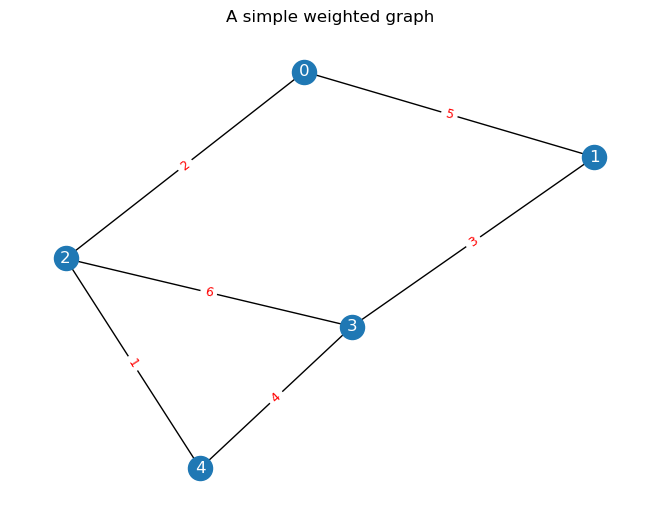

In [3]:
import matplotlib.pyplot as plt

G_x = nx.Graph()
G_x.add_edges_from([(0, 1), (0, 2), (1, 3), (2, 3), (2, 4), (3, 4)])

G_x[0][1]['weight'] = 5
G_x[0][2]['weight'] = 2
G_x[1][3]['weight'] = 3
G_x[2][3]['weight'] = 6
G_x[2][4]['weight'] = 1
G_x[3][4]['weight'] = 4

# Visualization
pos = nx.spring_layout(G_x, seed=42)
nx.draw(G_x, pos, with_labels=True, font_color='white')
edge_labels = nx.get_edge_attributes(G_x, 'weight')
nx.draw_networkx_edge_labels(G_x, pos, edge_labels=edge_labels, font_color='red', font_size=9)
plt.title(f"A simple weighted graph")
plt.show()

We pre-partition this graph to demonstrate how the annealer works (and that $H = \sum_{(i,j) \in E}{w_{ij}*(2x_ix_j-x_i-x_j)}$):

In [4]:
partition = {0: 1,  1: 1,  2: 0,  3: 0,  4: 0} # Chosen graph partition (arbitrary)
total_H = 0.0 # Initial H
total_cut_weight = 0.0 # Initial sum of w_ij

print("\nEdge-wise:")
for u, v, data in G_x.edges(data=True):
    w_uv = data['weight']
    x_u = partition[u]
    x_v = partition[v]

    # QUBO term for this edge
    qubo_term = w_uv * (2 * x_u * x_v - x_u - x_v)
    total_H += qubo_term

    # Check if it's a cut edge
    if x_u != x_v:
        total_cut_weight += w_uv
        print(f"Edge ({u},{v}), w ={w_uv:2}, x_{u}={x_u}, x_{v}={x_v} -> QUBO term: {qubo_term:5.1f} (cut)")
    else:
        print(f"Edge ({u},{v}), w ={w_uv:2}, x_{u}={x_u}, x_{v}={x_v} -> QUBO term: {qubo_term:5.1f} (not cut)")

print(f"\nTotal QUBO Energy (H) = {total_H:.1f}")
print(f"Total Cut Weight      = {total_cut_weight:.1f}")


Edge-wise:
Edge (0,1), w = 5, x_0=1, x_1=1 -> QUBO term:   0.0 (not cut)
Edge (0,2), w = 2, x_0=1, x_2=0 -> QUBO term:  -2.0 (cut)
Edge (1,3), w = 3, x_1=1, x_3=0 -> QUBO term:  -3.0 (cut)
Edge (2,3), w = 6, x_2=0, x_3=0 -> QUBO term:   0.0 (not cut)
Edge (2,4), w = 1, x_2=0, x_4=0 -> QUBO term:   0.0 (not cut)
Edge (3,4), w = 4, x_3=0, x_4=0 -> QUBO term:   0.0 (not cut)

Total QUBO Energy (H) = -5.0
Total Cut Weight      = 5.0


Now that we have established that minimizing our QUBO energy $H$ is equivalent to maximizing the cut weight, we can utilize the D-Wave quantum annealer (or its simulator, in our case) to find the partition. The annealer is designed to search for the assignment of $x_i$ values (the partition) that results in the minimum possible energy $H$, thereby identifying the (near-)optimal Max-Cut (*heuristically!!!*).

H = -20.0
Max Cut Weight: 20.0


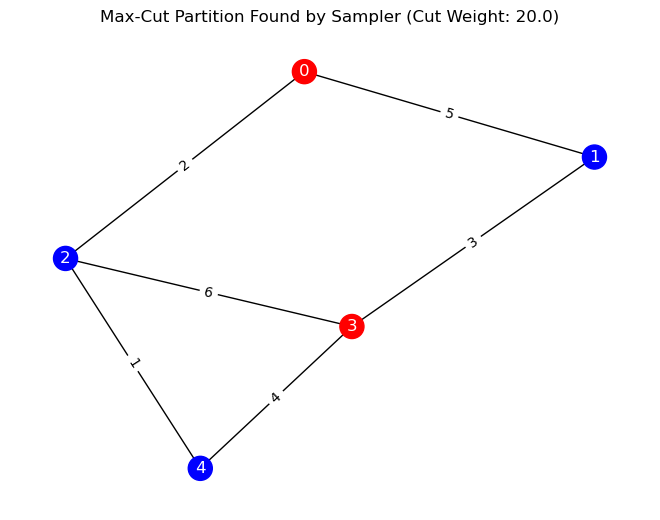

In [5]:
import dimod
import neal

bqm = BinaryQuadraticModel('BINARY') # Import a binary quadratic model

# Add "linear biases" (weights)
for node in G_x.nodes():
    linear_bias = 0
    for u, v, data in G_x.edges(node, data=True): # G.edges(node) gets edges incident to node
        weight = data.get('weight', 1.0)
        linear_bias -= weight
    bqm.add_linear(node, linear_bias)

# Add quadratic couplings (2x_i * x_j01 - x_i - x_j)
for u, v, data in G_x.edges(data=True):
    weight = data.get('weight', 1.0)
    bqm.add_quadratic(u, v, 2 * weight)

# Find the partition minimizing H usning sampler from neal
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100) # num_reads can be adjusted
best_solution = sampleset.first
found_partition_x_values = best_solution.sample # Dictionary {node: 0_or_1}
min_energy_H = best_solution.energy

# print(f"\nBest partition: {found_partition_x_values}")
print(f"H = {min_energy_H:.1f}")

# Calculate the cut weight
max_cut_weight_found = 0
for u, v, data in G_x.edges(data=True):
    weight = data.get('weight', 1.0)
    if found_partition_x_values[u] != found_partition_x_values[v]:
        max_cut_weight_found += weight

print(f"Max Cut Weight: {max_cut_weight_found:.1f}")

# Visualize 
pos = nx.spring_layout(G_x, seed=42)
node_colors = ['red' if found_partition_x_values[node] == 0 else 'blue' for node in G_x.nodes()]
edge_weights_labels = nx.get_edge_attributes(G_x, 'weight')

nx.draw(G_x, pos, with_labels=True, node_color=node_colors, font_color='white')
nx.draw_networkx_edge_labels(G_x, pos, edge_labels=edge_weights_labels)
plt.title(f"Max-Cut Partition Found by Sampler (Cut Weight: {max_cut_weight_found:.1f})")
plt.show()

Now, we generalise this approach as a function that returns $H$, the cut weight, as well as the cut size:

In [6]:
def solve_max_cut(graph, weight_attribute='weight', num_reads=100):

    bqm = dimod.BinaryQuadraticModel('BINARY') # Import a binary quadratic model

    # Add "linear biases" (weights)
    for node in graph.nodes():
        linear_bias = 0.0 # Initialize as float
        for _, _, data in graph.edges(node, data=True):
            weight = data.get(weight_attribute, 1.0)
            if weight is None: weight = 1.0 # Handle None weights
            linear_bias -= float(weight)
        bqm.add_linear(node, linear_bias)

    # Add quadratic couplings
    for u, v, data in graph.edges(data=True):
        weight = data.get(weight_attribute, 1.0)
        if weight is None: weight = 1.0 # Handle None weights
        bqm.add_quadratic(u, v, 2.0 * float(weight))

    # Find the partition minimizing H using sampler from neal
    sampler = neal.SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=num_reads) # num_reads can be adjusted

    if not sampleset:
        print("Sampler returned an empty sampleset. Cannot determine solution.")
        return None, None, None, sampleset

    try:
        best_solution = sampleset.first
        found_partition = best_solution.sample # Dictionary {node: 0_or_1}
        min_energy_H = best_solution.energy
    except (AttributeError, IndexError):
        print("Error accessing best solution from sampleset.")
        return None, None, None, sampleset


    # Calculate the cut weight for the found partition
    max_cut_weight_found = 0.0 # Initialize as float
    for u, v, data in graph.edges(data=True):
        weight = data.get(weight_attribute, 1.0)
        if weight is None: weight = 1.0
        # Ensure u and v are in the found_partition (should be if BQM was built from graph.nodes)
        if u in found_partition and v in found_partition and found_partition[u] != found_partition[v]:
            max_cut_weight_found += float(weight)
        elif u not in found_partition or v not in found_partition:
            print(f"Warning: Node {u if u not in found_partition else v} from edge ({u},{v}) not in partition solution.")

    return min_energy_H, max_cut_weight_found, found_partition, sampleset

... and we apply this function to our original graph (with a high value of `num_reads`):

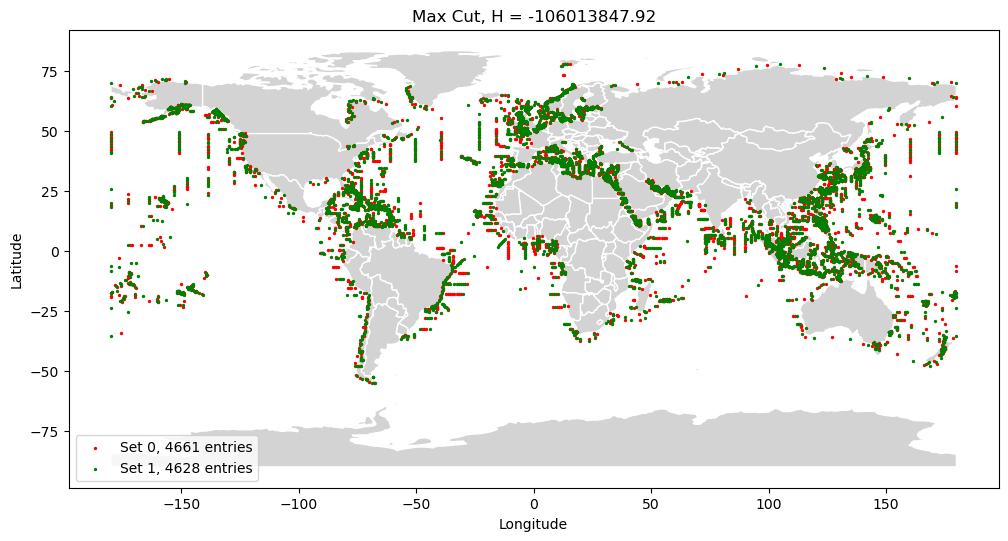

In [7]:
g_h, g_w, g_p, g_s = solve_max_cut(G, weight_attribute="edge_attr", num_reads=1000) # Solve Max Cut

gdf_nodes_part = gdf_nodes.copy(deep=False)
gdf_nodes_part['partition'] = [g_p[node] for node in gdf_nodes_part['node_id']]
cut_side_plot_0 = gdf_nodes_part[gdf_nodes_part.partition == 0]
cut_side_plot_1 = gdf_nodes_part[gdf_nodes_part.partition == 1]

fig, ax = plt.subplots(figsize=(12, 8))
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color="lightgray", edgecolor="white")
cut_side_plot_0.plot(ax=ax, color="red",  markersize=2, label=f"Set 0, {cut_side_plot_0.shape[0]} entries")
cut_side_plot_1.plot(ax=ax, color="green",  markersize=2, label=f"Set 1, {cut_side_plot_1.shape[0]} entries")

ax.set_title(f"Max Cut, H = {round(g_h, 2)}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

Thus, we have simulated how we would heuristically find the max cut in our graph using D-Wave's Ocean SDK and the `neal` package more specifically. This provides us with an overview of the most critical bi-partition of our undersea cable network. $-H$ represents the sum of all bandwidth values between these two (potentially disjoint) sets. This value therefore represents the maximum amount of data bandwith (by a stretch, given how arbitrarily we defined bandwidth in notebook 1) **loss** that can be achieved by splitting the network in two. In other words, the edges in our max cut solution are those whose combined bandwidth is the highest connecting the two partitions. A *highest capacity fault line*, if you will.

We could use this information to identify potential chokepoints, find just how vulnerable our network potentially is and assist with disaster recovery planning. It could also be used for less harmful aims, such as network partition (e.g., for administrative reasons) or simply understanding global domains of influence on the network.